<a href="https://colab.research.google.com/github/twisha-k/Python_notes/blob/main/60_coding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 60: Simple Linear Regression - Model Evaluation

### Teacher-Student Activities

In this class, we will learn to evaluate the accuracy of a simple linear regression model by calculating the coefficient of determination, MSE, RMSE and MAE values.

We will also learn how to build a linear regression model using the `sklearn` module to avoid using the math behind it.

Let's quickly run the codes covered in the previous classes and begin this session from **Activity 1: The Coefficient of Determination (R-Squared)** section.

---

### Recap

In [ ]:
# Run the code cell.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Loading the dataset.
csv_file = 'https://s3-student-datasets-bucket.whjr.online/whitehat-ds-datasets/air-quality/AirQualityUCI.csv'
df = pd.read_csv(csv_file, sep=';')

# Dropping the 'Unnamed: 15' & 'Unnamed: 16' columns.
df = df.drop(columns=['Unnamed: 15', 'Unnamed: 16'], axis=1)

# Dropping the null values.
df = df.dropna()

# Creating a Pandas series containing 'datetime' objects.
dt_series = pd.Series(data = [item.split("/")[2] + "-" + item.split("/")[1] + "-" + item.split("/")[0] for item in df['Date']], index=df.index) + ' ' + pd.Series(data=[str(item).replace(".", ":") for item in df['Time']], index=df.index)
dt_series = pd.to_datetime(dt_series)

# Remove the Date & Time columns from the DataFrame and insert the 'dt_series' in it.
df = df.drop(columns=['Date', 'Time'], axis=1)
df.insert(loc=0, column='DateTime', value=dt_series)

# Get the Pandas series containing the year values as integers.
year_series = dt_series.dt.year

# Get the Pandas series containing the month values as integers.
month_series = dt_series.dt.month

# Get the Pandas series containing the day values as integers.
day_series = dt_series.dt.day

# Get the Pandas series containing the days of a week, i.e., Monday, Tuesday, Wednesday etc.
day_name_series = dt_series.dt.day_name()

# Add the 'Year', 'Month', 'Day' and 'Day Name' columns to the DataFrame.
df['Year'] = year_series
df['Month'] = month_series
df['Day'] = day_series
df['Day Name'] = day_name_series

# Sort the DataFrame by the 'DateTime' values in the ascending order. Also, display the first 10 rows of the DataFrame.
df = df.sort_values(by='DateTime')

# Create a function to replace the commas with periods in a Pandas series.
def comma_to_period(series):
    new_series = pd.Series(data=[float(str(item).replace(',', '.')) for item in series], index=df.index)
    return new_series

# Apply the 'comma_to_period()' function on the ''CO(GT)', 'C6H6(GT)', 'T', 'RH' and 'AH' columns.
cols_to_correct = ['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH'] # Create a list of column names.
for col in cols_to_correct: # Iterate through each column
    df[col] = comma_to_period(df[col]) # Replace the original column with the new series.

# Remove all the columns from the 'df' DataFrame containing more than 10% garbage value.
df = df.drop(columns=['NMHC(GT)', 'CO(GT)', 'NOx(GT)', 'NO2(GT)'], axis=1)

# Create a new DataFrame containing records for the years 2004 and 2005.
aq_2004_df = df[df['Year'] == 2004]
aq_2005_df = df[df['Year'] == 2005]

# Replace the -200 value with the median values for each column having indices between 1 and -4 (excluding -4) for the 2004 year DataFrame.
for col in aq_2004_df.columns[1:-4]:
  median = aq_2004_df.loc[aq_2004_df[col] != -200, col].median()
  aq_2004_df[col] = aq_2004_df[col].replace(to_replace=-200, value=median)

# Repeat the same exercise for the 2005 year DataFrame.
for col in aq_2005_df.columns[1:-4]:
  median = aq_2005_df.loc[aq_2005_df[col] != -200, col].median()
  aq_2005_df[col] = aq_2005_df[col].replace(to_replace=-200, value=median)

# Group the DataFrames about the 'Month' column.
group_2004_month = aq_2004_df.groupby(by='Month')
group_2005_month = aq_2005_df.groupby(by='Month')

# Concatenate the two DataFrames for 2004 and 2005 to obtain one DataFrame.
df = pd.concat([aq_2004_df, aq_2005_df])

# Information of the DataFrame.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9357 entries, 0 to 9356
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   DateTime       9357 non-null   datetime64[ns]
 1   PT08.S1(CO)    9357 non-null   float64       
 2   C6H6(GT)       9357 non-null   float64       
 3   PT08.S2(NMHC)  9357 non-null   float64       
 4   PT08.S3(NOx)   9357 non-null   float64       
 5   PT08.S4(NO2)   9357 non-null   float64       
 6   PT08.S5(O3)    9357 non-null   float64       
 7   T              9357 non-null   float64       
 8   RH             9357 non-null   float64       
 9   AH             9357 non-null   float64       
 10  Year           9357 non-null   int64         
 11  Month          9357 non-null   int64         
 12  Day            9357 non-null   int64         
 13  Day Name       9357 non-null   object        
dtypes: datetime64[ns](1), float64(9), int64(3), object(1)
memory usage: 1.1+

The description for all the columns containing data for air pollutants, temperature, relative humidity and absolute humidity is provided below.


|Columns|Description|
|-|-|
|PT08.S1(CO)|PT08.S1 (tin oxide) hourly averaged sensor response (nominally $\text{CO}$ targeted)|
|C6H6(GT)|True hourly averaged Benzene concentration in $\frac{\mu g}{m^3}$|
|PT08.S2(NMHC)|PT08.S2 (titania) hourly averaged sensor response (nominally $\text{NMHC}$ targeted)|
|PT08.S3(NOx)|PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally $\text{NO}_x$ targeted)|
|PT08.S4(NO2)|PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally $\text{NO}_2$ targeted)|
|PT08.S5(O3) |PT08.S5 (indium oxide) hourly averaged sensor response (nominally $\text{O}_3$ targeted)|
|T|Temperature in Â°C|
|RH|Relative Humidity (%)|
|AH|AH Absolute Humidity|

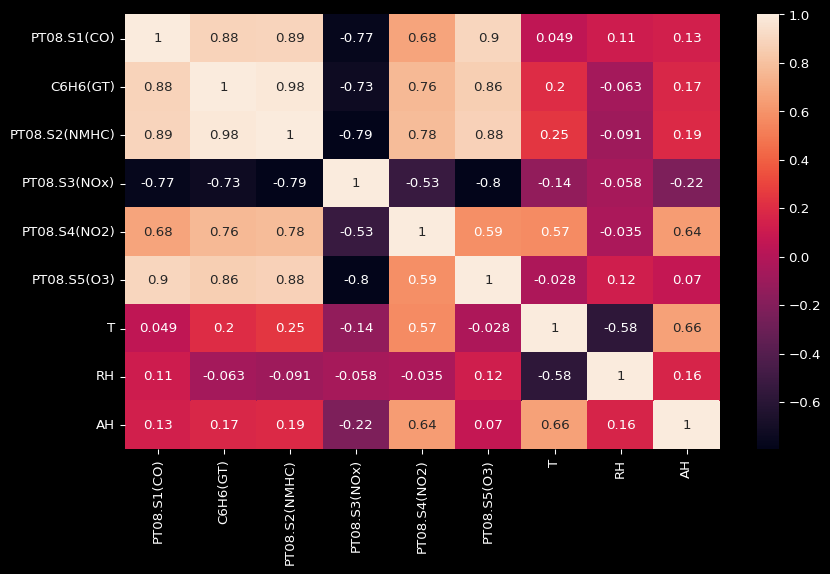

In [ ]:
# Heatmap to pinpoint the columns in the 'df' DataFrame exhibiting high correlation.
corr_df = df.iloc[:, 1:-4].corr()
plt.figure(figsize = (10, 6), dpi = 96)
sns.heatmap(data = corr_df, annot = True) # 'annot=True' fills the R values in the heatmap cells.
plt.show()

---

#### Train-Test Split

There is no fixed rule to what should be the size of train and test sets. However, the training set should always have more instances than the test set. So in general, you can have the 70% of instances in the train set and the remaining 30% in the test set. In general, you may split a DataFrame in such a way that a train set contains 67% to 80% of the instances.


In [ ]:
# Splitting the DataFrame into the train and test sets.
from sklearn.model_selection import train_test_split

X = df['T'] # Pandas DataFrame containing only feature variables
y = df['RH'] # Pandas Series containing the target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42) # Test set will have 33% of the values.

If you don't specify the `random_state` parameter in your code, then every time you run (or execute) your code, a new random value is generated and the train and test datasets will have different values each time.

However, if a fixed value is assigned like `random_state = 42` then regardless of the number of times you execute your code, the result will be the same i.e., same values in train and test datasets.


---

#### Model Training

Let the equation of the best fit line be $$y = mx + c$$

Here,
- $y$ represents the relative humidity values on the $y$-axis
- $x$ represents the temperatures values on the $x$-axis
- $m$ is the slope of the line
- $c$ is the intercept made by the line on the $y$-axis


$$\Rightarrow m = \frac{\sum(x_i - \bar{x})(y_i - \bar{y})}{\sum (x_i - \bar{x})^2}$$


where
- $x_i$ is each instance of the feature variable. In this case, $x_i$ represents each temperature value.

- $\bar{x}$ is the average (or mean) value of the feature variable. In this case, $\bar{x}$ is the average temperature value.

- $y_i$ is each instance of the target variable. In this case, $y_i$ represents each relative humidity value.

- $\bar{y}$ is the average (or mean) value of the target variable. In this case, $\bar{y}$ is the average relative humidity value.

- $n$ is the total number of instances.


The intercept i.e. $c$ is given by
$$c = \bar{y} - m \bar{x}$$


**Note:** The differences between a value and the mean value is also referred to as **residuals** or **errors**.


In [ ]:
# Create the 'errors_product()' and 'squared_errors()' function.
def errors_product():
  prod = (X_train - X_train.mean()) * (y_train - y_train.mean())
  return prod

def squared_errors():
  sq_errors = (X_train - X_train.mean()) ** 2
  return sq_errors

# Calculate the slope and intercept values for the best fit line.
slope = errors_product().sum()/ squared_errors().sum()
intercept = y_train.mean() - slope * X_train.mean()

print(f"Slope: {slope} \nIntercept: {intercept}")

Slope: -1.1120539107947718 
Intercept: 69.69110324644882


As you can see, we have obtained the slope and intercept values for the best fit line.

Hence, the required equation of the best fit line is
$$y = -1.1120x + 69.6911$$

or
$$\text{relative humidity} =  -1.1120 \times \text{temperature} + 69.6911$$

which is also the regression line.

Let's plot this line along with the scatter plot to see how well it fits the points.

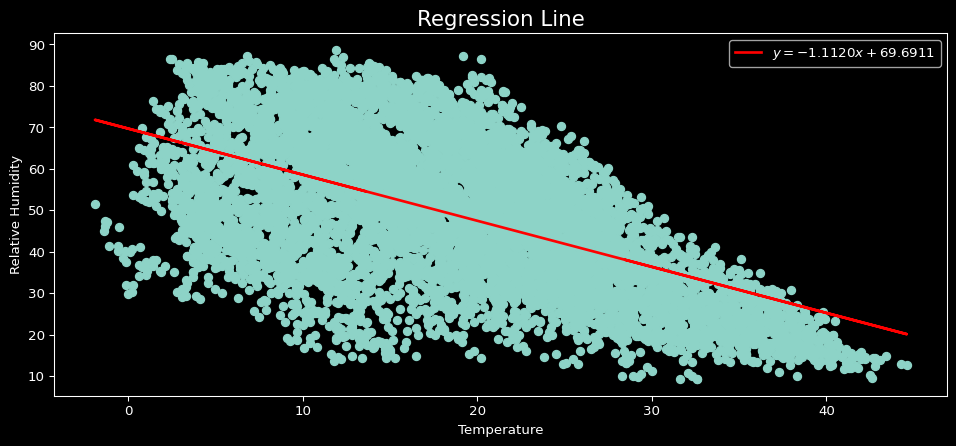

In [ ]:
# Plot the regression line in the scatter plot between relative humidity and temperature values.
plt.style.use('dark_background')
plt.figure(figsize = (12, 5), dpi = 96)
plt.title("Regression Line", fontsize = 16)
plt.scatter(df['T'], df['RH'])
plt.plot(df['T'], slope * df['T'] + intercept, color = 'r', linewidth = 2, label = '$y = −1.1120x + 69.6911$')
plt.xlabel("Temperature")
plt.ylabel("Relative Humidity")
plt.legend()
plt.show()

From the naked eye observation, it seems the regression line that we obtained fits pretty well all the points in the scatter plot. But let's evaluate our model using Coefficient of Determination (R-squared).

---

#### Activity 1: The Coefficient of Determination (R-Squared)^

The R-squared ($R^2$) tells us how much of the variance in one variable explains the variance in another variable. It is usually reported in terms of percentage.

Let's compute the coefficient of determination value which is one of the parameters that explains how much variation in one variable can be explained by the other variable through the linear regression model.

$$R^2 = 1 - \frac{\text{SSE}}{\text{SST}}$$

where

$$\text{SSE} = \sum(y - y_{\text{pred}})^2$$

and

$$\text{SST} = \sum(y - \bar{y})^2$$

**SSE** stands for the sum of squared errors i.e. errors between the actual and the predicted values. Consider the image shown below. Let there be 6 points on the scatter plot between the $x$ and $y$ values.

<center><img src = 'https://student-datasets-bucket.s3.ap-south-1.amazonaws.com/images/sse1.png' width = 700></center>

Let there be a straight line which fits them the best as shown in the image below.

<center><img src = 'https://student-datasets-bucket.s3.ap-south-1.amazonaws.com/images/sse2.png' width = 700></center>

The points marked with the blue colour on the straight line are the corresponding predicted values to the red-coloured points. Let the arrows denote the distances between the blue and the red coloured points as shown in the image below.

<center><img src = 'https://student-datasets-bucket.s3.ap-south-1.amazonaws.com/images/sse3.png' width = 700></center>

The sum of these distances is the **squared sum of errors (SSE)**. These distances would have been lower if the red-coloured points were more close to the regression line as shown in the image below.

<center><img src = 'https://student-datasets-bucket.s3.ap-south-1.amazonaws.com/images/sse4.png' width = 700></center>

Hence, the SSE value would have been lower. The distance between the actual values and the predicted values are given by
$$|y_i - \hat{y_i}|$$
where
- $y_i$ is the $y$-coordinate of the actual value and
- $\hat{y_i}$ is the $y$-coordinate of the corresponding predicted value

<center><img src = 'https://student-datasets-bucket.s3.ap-south-1.amazonaws.com/images/sse5.png' width = 700></center>

Lower the **SSE** value, higher the $R^2$ value. Higher the $R^2$ value, better is accuracy.

**SST** stands for the sum of squared **total** i.e. the errors between the actual values and their mean. Consider the image shown below.

<center><img src = 'https://student-datasets-bucket.s3.ap-south-1.amazonaws.com/images/sst1.png' width = 700></center>

The mean of the actual target variable values i.e. $\bar{y}$ tries to fit all the points. The arrows represent the distances between the points and their mean values.

The sum of these distances is the **squared sum of total (SST)**. They are given by
$$|y_i - \bar{y}|$$
where
- $y_i$ is the $y$-coordinate of the actual value and
- $\bar{y}$ is their mean value

<center><img src = 'https://student-datasets-bucket.s3.ap-south-1.amazonaws.com/images/sst2.png' width = 700></center>

Also, it is the maximum possible error because the mean line is the worst fit line unless the points follow uniform distribution.

**Note:**

1. The terms **error, residual, difference** mean the same thing.
2. It goes without saying that the $R^2$ value will be between 0 and 1.


Let's define a function to calculate the $R^2$ value which will take 2 input parameters; feature dataset `X` and target series `y`. Let's name this function `r_squared()`. It should return the coefficient of determination value`. The following operations are to be performed inside the function:

1. Calculate the predicted values for the target variable using the $y = mx + c$ formula and store it in the `y_pred` variable.

2. Calculate the squared errors between the actual `y` values and the predicted `y` values i.e `y_pred`. Store them in the `sq_error` variable.

3. Calculate the squared total between the actual `y` values and the mean of the `y` values. Store them in the `sq_total` variable.

4. Calculate the sum of both the `sq_error` and `sq_total` series and then calculate the $R^2$ value using its formula.


Then calculate the $R^2$ value for the training set by using the `r_squared()` function.

In [ ]:
# S1.1: Calculate the r-squared value for the training set.
"""def r_squared(x,y):
  y_pred=slope*x+intercept
  SSE=(y−y_pred)**2.sum()
  SST=(y−y.mean())**2.sum()
  𝑅_squa=1−SSE/SST
  return R_squa
r_squared(X_train,y_train)"""

'def r_squared(x,y):\n  y_pred=slope*x+intercept\n  SSE=(y−y_pred)**2.sum()\n  SST=(y−y.mean())**2.sum()\n  𝑅_squa=1−SSE/SST\n  return R_squa\nr_squared(X_train,y_train)'

In [ ]:
def r_squared(x,y):
  y_pred= slope*x+intercept
  sse = ((y-y_pred)**2).sum()
  sst = ((y-y.mean())**2).sum()
  r_sq = 1-(sse/sst)
  return r_sq
r_squared(X_train,y_train)

0.3246891031812874

The $R^2$ value is 32.46% approximately which denotes that 32.46% of the variance between the relative humidity and temperature is explained by the linear regression but the remaining 67.54% of the variance is still there.

Ideally, the $R^2$ value should be as close to 1 as possible for a best fit regression line.

**Note:** The $R^2$ value is a square of the correlation coefficient.


Let's calculate the square of the correlation coefficient to validate the above statement with the help of any one value by applying `np.corrcoef()` function on `X_train` and `y_train`.

In [ ]:
# S1.2: Calculate R-squared value by squaring the correlation coefficient value.
np.corrcoef(X_train,y_train)[0,1]**2

0.3246891031812878

As it can be observed both the values are the same. Let's calculate the $R^2$ value for the test set as well.

In [ ]:
# S1.3: Calculate R-squared value for the test set.
r_squared(X_test,y_test)

0.3462678878157637

---

#### Activity 2: MSE, RMSE, MAE^^

Mean Squared Errors (MSE) is the mean of squares of the difference between the actual and the predicted values i.e.

$$\text{MSE} = \frac{1}{n} \sum(y_\text{actual} - y_\text{predicted})^2$$

where
- $y_\text{actual}$ is the set of actual values of the target variable

- $y_\text{predicted}$ is the set of predicted values of the target variable obtained by deploying some kind of prediction model

- $n$ is the total number of values

Root Mean Squared Errors (RMSE) is the square root of the mean squared errors (MSE) i.e.

$$\text{RMSE} = \sqrt{\frac{1}{n} \sum(y_\text{actual} - y_\text{predicted})^2}$$

$$\Rightarrow \text{RMSE} = \sqrt{\text{MSE}}$$

Mean Absolute Errors (MAE) is the mean of absolute values of the differences between the actual and the predicted values i.e.

$$\text{MAE} = \frac{1}{n} \sum \left|y_\text{actual}- y_\text{predicted} \right|$$

Let's create `mean_sq_error()`,`root_mean_sq_error()` and `mean_abs_error` functions to calculate the MSE, RMSE and MAE values using the above formulae respectively.

In [ ]:
from pandas.core.common import random_state
# S2.1: Create functions to calculate the MSE, RMSE and MAE values.
def mean_sq_error(x,y):
  y_pred=slope*x+intercept
  n = len(y)
  mse=((1/n)*(y-y_pred)**2).sum()
  return mse
def root_mean_sq_error(x,y):
  n = len(y)
  y_pred=slope*x+intercept
  rmse=np.sqrt(((1/n)*(y-y_pred)**2).sum())
  return rmse
def mean_abs_error(x,y):
  y_pred=slope*x+intercept
  n = len(y)
  mae=(1/n)*np.sum((np.abs(y-y_pred)))
  return mae

Let's call the functions created above to calculate the MSE, RMSE and MAE values for the train and test sets.

Also, round up the result (or output) upto 3 decimal places.

In [ ]:
# S2.2: Calculate the MSE, RMSE and MAE values on the train and test sets.
print(r_squared(X_train,y_train))
print(mean_sq_error(X_train,y_train))
print(root_mean_sq_error(X_train,y_train))
print(mean_abs_error(X_train,y_train))
print("test datset")
print(r_squared(X_test,y_test))
print(mean_sq_error(X_test,y_test))
print(root_mean_sq_error(X_test,y_test))
print(mean_abs_error(X_test,y_test))


195.28087173171838
13.974293246233184
11.289204138480198
test datset
187.02621686903166
13.675752881250512
11.149712275793021


The closer the MSE, RMSE and MAE values are to zero, the better is accuracy of a regression-based prediction model. However, in the case of fractional values (or values between 0 and 1), MAE is a better metric to evaluate the accuracy of a regression-based prediction model. This is because squaring fractional values will take them even more close to zero, e.g. $0.1^2 = 0.01$

---

#### Activity 3: Simple Linear Regression Using `sklearn` Module^^^

If you don't like the math behind linear regression, then you can use the `sklearn` (or Scikit-Learn) Python module for machine learning to implement the linear regression model using its `linear_model` module.

However, as a prerequisite to the `sklearn.linear_model` module, the feature and target variable sets should be two-dimensional arrays. Hence, first, you need to reshape the feature and the target variable arrays into two-dimensional arrays as currently they are one-dimensional arrays.

In [ ]:
# S3.1: Print the dimensions of the feature and target variable arrays/series.
print(X_train.shape)
from sklearn.linear_model import LinearRegression
skl_obj = LinearRegression()
X_train_reshape,y_train_reshape = X_train.values.reshape(-1,1),y_train.values.reshape(-1,1)
skl_obj.fit(X_train_reshape,y_train_reshape)
#skl_obj.prediction(X_test)

(6269,)


LinearRegression()

To convert a one-dimensional array into a two-dimensional array, use the `reshape(-1, 1)` function of `numpy` module.

The `reshape(-1, 1)` function does not work on a Pandas series. It works on a NumPy array. Hence, you need to create a NumPy array from a Pandas series. So, either you can convert a Pandas series into a NumPy array using the `array()` function of the `numpy` module or you can use the `values` attribute of the Pandas series object.

In [ ]:
# S3.2: Create two-dimensional NumPy arrays from one-dimensional Pandas series for the feature and target variables.


Now, let's deploy a linear regression model using the `sklearn` module. For this, follow the steps given below:

1. Import the `LinearRegression` class from the `sklearn.linear_model` module.
2. Create an object of the `LinearRegression` class.
3. Call the `fit()` function on the `LinearRegression` object with the input parameters as `X_train_reshaped` and `y_train_reshaped`.

The `fit()` function of the `LinearRegression` class will calculate the slope and intercept of the best fit line which you can get by calling the `coef_` and `intercept_` attributes respectively on the `LinearRegression` object.

**Syntax:**
> For slope: `object_name.coef_`

> For intercept: `object_name.intercept_`

In [ ]:
# S3.3: Deploy linear regression model using the 'sklearn.linear_model' module.
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
X_test_reshape,y_test_reshape = X_test.values.reshape(-1,1),y_test.values.reshape(-1,1)
y_test_predicted=skl_obj.predict(X_test_reshape)
y_train_predicted=skl_obj.predict(X_train_reshape)
print("r2_score test",r2_score(y_test,y_test_predicted))
print("r2_score train",r2_score(y_train,y_train_predicted))
print("RMSE test",np.sqrt(mean_squared_error(y_test_reshape,y_test_predicted)))
print("RMSE train",np.sqrt(mean_squared_error(y_train_reshape,y_train_predicted)))
print("MSE test",mean_squared_error(y_test_reshape,y_test_predicted))
print("MSE train",mean_squared_error(y_train_reshape,y_train_predicted))
print("MAE test",mean_absolute_error(y_test_reshape,y_test_predicted))
print("MAE train",mean_absolute_error(y_train_reshape,y_train_predicted))

0.3462678878157639
0.3246891031812873
13.675752881250508


As you can see the slope and intercept values are the same as we got earlier without using the `sklearn` module to build a linear regression model.

Now let's predict the values for both training and test sets and evaluate the model with the help of R-squared, MSE, RMSE and MAE parameters. For this, again you can use the `sklearn` module.

1. Import `r2_score, mean_squared_error` and `mean_absolute_error` functions from the `sklearn.metrics` module.

2. Calculate the predicted values (here `y_train_pred` and `y_test_pred`) for the feature variables (here `X_train_reshaped` and `X_test_reshaped`) by calling the `predict()` function on the `LinearRegression` object. The `predict()` function takes the feature variable set as an input.

3. Calculate the $R^2$, MSE, RMSE and MAE values using the following syntax:
   > `function_name(actual_target, predicted_target)`

   E.g., `r2_score(y_train_reshaped, y_train_pred)`

**Note:** The `sklearn.metrics` module does not have a dedicated function to calculate the RMSE value. However, it can be calculated by taking the square-root of the MSE value using `sqrt()` of the `numpy` module.


In [ ]:
# S3.4: Evaluate the linear regression model using the 'r2_score', 'mean_squared_error' & 'mean_absolute_error' functions of the 'sklearn' module.


As it can be seen the R-squared, MSE, RMSE and MAE values are the same as we got earlier without using the `sklearn` module to build a linear regression model.

Let's stop here. In the next class, we will learn residual analysis before we can conclude on the accuracy and efficacy of a linear regression model. We will learn more concepts of learning linear regression as well.


---

### **Project**
You can now attempt the **Applied Tech. Project 60 - Simple Linear Regression III - Model Evaluation** on your own.

**Applied Tech. Project 60 - Simple Linear Regression III - Model Evaluation**: https://colab.research.google.com/drive/1N-dDFw8zhfw7yKCrrEaN3xz8XepFnM0Z?usp=sharing

---